# Chapter 13. Loading and Preprocessing Data with TensorFlow

到目前为止，我们只使用适合内存的数据集，但深度学习系统通常在不适合RAM的非常大的数据集上进行训练。与其他深度学习库一起实现大型数据集并对其进行高效预处理可能很棘手，但由于Data API，TensorFlow使其变得容易：您只需创建一个数据集对象，并告诉它从哪里获取数据以及如何转换数据。TensorFlow负责所有实现细节，如multithreading、queuing、batching和prefetching。此外，Data API 与 `tf.keras` 无缝协作！

Data API 可以从文本文件（如CSV文件）、具有固定大小记录的二进制文件以及使用 TensorFlow 的 TFRecord 格式的二进制文件中读取，该格式支持不同大小的 records。 TFRecord是一种基于协议缓冲区（一种开源二进制格式）的灵活高效的二进制格式。Data API还支持从SQL数据库读取。此外，许多开源扩展可以从各种数据源读取，例如谷歌的 BigQuery 服务。

高效读取巨大的数据集并不是唯一的困难：数据还需要预处理，通常是 normalize。此外，它并不总是严格由方便的数字字段组成：可能有文本特征、类别特征等。这些需要编码，例如使用 one-hot编码、bag-of-words 编码或 `embeddings`（正如我们将看到的，`embeddings` 是代表类别或 token 的可训练的稠密矢量）。处理所有这些预处理的一个选项是编写您自己的自定义预处理层。另一个是使用 Keras 提供的标准预处理层。

在本章中，我们将介绍 Data API、TFRecord 格式，以及如何创建自定义预处理层并使用标准 Keras 层。我们还将快速查看TensorFlow 生态系统中的一些相关项目：

- TF Transform (`tf.Transform`): 可以编写单个预处理函数，该函数可以在训练前（加快速度）在完整训练集的批量模式下运行，然后导出到 TF Function 并集成到训练模型中，以便一旦在生产中部署，它就可以随时处理新实例。
- TF Datasets (TFDS): 提供了一个方便的功能来下载许多常见的各种数据集，包括 ImageNet 等大型数据集，以及方便的 dataset 对象，以使用Data API操作它们。

## The Data API

整个 Data API 围绕着 `dataset` 的概念：正如您猜的那样，这代表了一系列 data items。通常，您将使用逐渐从磁盘读取数据的 datasets，但为了简单起见，让我们使用 `tf.data.Dataset.from_tensor_slices()` 创建整个在 RAM 里的 dataset:

In [1]:
import tensorflow as tf
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

Metal device set to: Apple M1


2022-05-11 19:21:56.110117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-11 19:21:56.110463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<TensorSliceDataset shapes: (), types: tf.int32>

`from_tensor_slices` 函数一个tensor作为输入， 创建一个 `tf.data.Dataset` 其元素是 `X` 的 是 slices(沿着第一维)， 因此，此数据集包含10 items：tensors 0、1、2、...、9。在这个例子中我们可以使用 `tf.data.Dataset.range(10)`  得到相同的 dataset。

您可以简单地迭代 dataset 的 items，如下所示：

In [2]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### Chaining Transformations

一旦您有了数据集，您可以通过调用其 transformations 方法对它应用各种 transformation。每个方法都会返回一个新的 dataset，因此您可以像这样链式 transformations:

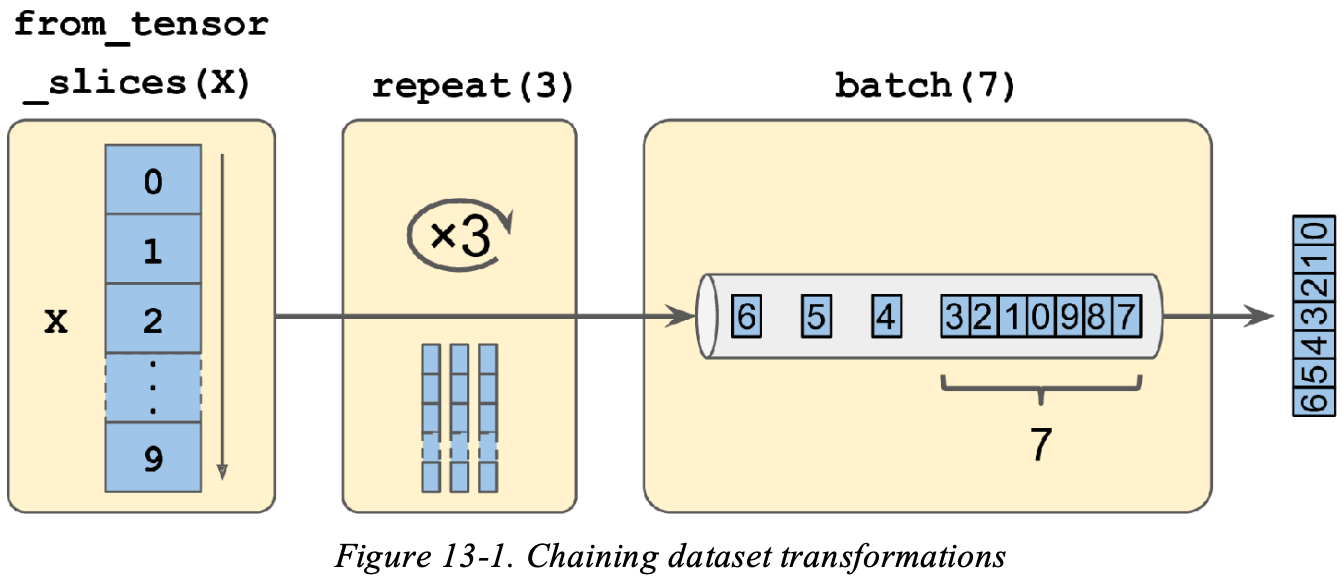

In [3]:
# repeat 类似 epoch
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


在本例中，我们首先调用原始 dataset 上的 `repeat` 方法，它返回一个新的dataset，该数据集将重复原始 dataset 三次。当然，这不会三次复制内存中的所有数据!(如果您在没有参数的情况下调用此方法，新 dataset 将永远重复源 dataset，因此迭代数据集的代码必须决定何时停止。)然后，调用 `batch()` 方法处理这个新 dataset，这再次创建一个新 dataset。这将分 7 个 items 分批对上一个 dataset 的 item 进行分组。最后，我们迭代了这个最终数据集的 items。如您所见，`batch` 方法必须输出最后一批的 batch 大小为2而不是7，但是，如果您希望它放弃这最后一批，您可以调用 `drop_remainder=True`，以便所有批次的大小完全相同。

> WARNING: dataset 方法不会修改 dataset，而是创建新的 dataset，因此请确保保留对这些新 dataset的引用（例如，dataset = ），否则什么都不会发生。

您还可以通过调用 `map` 方法来转换 items。例如，这会创建一个新的 dataset，所有 items 都翻了一番：

In [4]:
dataset = dataset.map(lambda x: x * 2) # Items: [0, 2, 4, 6, 8, 10, 12]

您将调用此函数，以将您想要的任何预处理应用于您的数据。有时，这将包括可能相当密集的计算，例如 reshaping 或 rotating 图像，因此您通常希望生成多个线程来加快速度：只需设置 `num_parallel_calls` 参数。注意你传入 `map()` 方法的函数必须可以转换为 TF Function。

当 `map()` 方法对每个 item 应用 transformation 时，`apply()` 方法将转换应用于整个数据集。例如，以下代码将 `unbatch` 函数应用于数据集（此函数目前是 experimental 的，但它很可能会在未来的版本中移动到核心API）。新 dataset 中的每个 item 都将是一个 single-integer 张量，而不是 7 个 integers 的一批：

In [5]:
# tf.data.Dataset.unbatch()
dataset = dataset.apply(tf.data.experimental.unbatch()) # Items: 0, 2, 4, ...

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


也可以简单地使用 `filter()` 方法过滤数据集：

In [6]:
dataset = dataset.filter(lambda x: x < 10) # Items: 0 2 4 6 8 0 2 4 6...

您通常只想查看 dataset 中的几个 items。您可以为此使用 `take()` 方法：

In [7]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


2022-05-11 19:21:56.234997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-11 19:21:56.236559: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Shuffling the Data

如您所知，当训练集中的样本独立同分布时，梯度下降效果最好。确保这样做的简单方法是使用 `shuffle()` 方法 shuffle 样本。它将创建一个新的数据集，首先用源数据集的第一个 items 填充缓冲区。然后，每当它被要求一个 item 时，它都会从缓冲区中随机提取一个，并从源数据集中刷新一个新的项目替换，直到整个数据集都被迭代。此时，它继续从缓冲区随机提取 item，直到它为空。您必须指定缓冲区大小，使其足够大很重要，否则 shuffling 不会非常有效。 例如，以下代码创建并显示包含整数 0 至 9的数据集，重复 3 次，使用大小为 5 的缓冲区和 42 的随机种子进行 shuffle ，批大小为7：

In [8]:
dataset = tf.data.Dataset.range(10).repeat(3) 
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


> TIP: 如果您调用 `repeat()` 数据集，默认情况下，它将在每次迭代时生成一个新顺序。这通常是一个好主意，但如果您更喜欢在每次迭代中重用相同的顺序（例如，用于测试或调试），您可以设置 `reshuffle_each_iteration=False`


对于不适合内存的大型数据集，这种简单的 shuffling-buffer 方法可能还不够，因为与数据集相比，缓冲区会很小。一个解决方案是 shuffle 源数据本身(例如，在Linux上，您可以使用 `shuf` 指令)。 这肯定会大大改善 shuffling！即使源数据被洗牌，您通常也希望再洗牌一些，否则每个 epoch 都会重复相同的顺序，模型最终可能会有 bias（例如，由于源数据的顺序偶然出现一些虚假的模式）。为了进一步 shuffle 样本，一种常见的方法是将源数据拆分为多个文件，然后在训练期间按随机顺序读取它们。然而，位于同一文件中的样本最终仍然会彼此接近。为了避免这种情况，您可以随机选择多个文件并同时读取它们，交错它们的 records。除此之外，您还可以添加一个 shuffling buffer，使用 `shuffle()` 方法。这些听起来需要做很多工作，别担心：Data API只需几行代码即可实现这一切。

### Interleaving lines from multiple files

首先，假设您已经加载了 California housing dataset，shuffle 了它，并将其分为训练集、验证集和测试集。然后，您将每个集拆分为许多CSV文件，每个文件看起来都像这样(每行包含八个输入特征加上目标中位数房屋值):

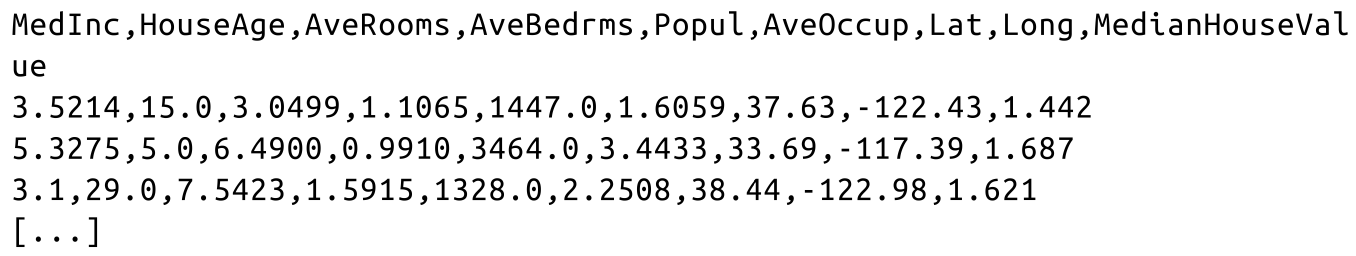

我们还假设 `train_filepaths` 包含训练文件路径列表(你也有 `valid_fileppaths` 和 `test_filepaths`):

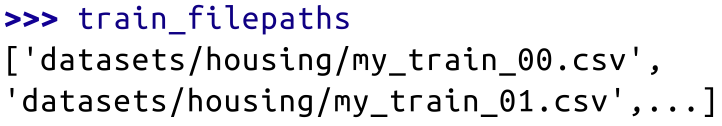

此外， 你还可以使用文件模式，例如， `train_filepaths = "datasets/housing/my_train_*.csv"`。 现在让我们创建一个数据集仅包含以下文件路径：

```python
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
```

默认情况下， `list_files()` 函数返回一个 dataset 其打乱了文件路径。通常来说这是一件好事， 但是如果你可以设置 `shuffle=False`。

接下来，您可以调用 `interleave()` 一次读取五个文件的方法，并交织它们的行（使用 `skip()` 方法跳过每个文件的第一行，即的标题行：

```python
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)
```

`interleave()` 方法将会创建一个 dataset, 其从 `filepath_dataset` 中抽取 5 个文件路径， 对每个文件会调用你给它的方法(在这个例子中是一个 lambda 表达式) 来创建一个新的 dataset (在这个例子中是 `TextLineDataset`)。 需要澄清的是，在现阶段，总共将有 7 个数据集：filepath dataset、interleave dataset 和 5 个由 interleave dataset 在创建的 `TextLineDatasets`。 当我们迭代 `interleave dataset` 时，它将循环浏览这 5 个 `TextLineDatasets`，每次读一行，直到所有数据集都用完。然后它将从 `filepath_dataset` 获得接下来的五个文件路径
并以同样的方式 interleave 它们，直到文件路径用完。

> TIP: 为了使 interleaving 效果最佳，最好有相同长度的文件；否则最长文件的末端不会 interleaving 。

默认情况下， `interleave()` 不会并行； 它只是按顺序从每个文件中读取一行。如果你想让它真正读取文件并行, 你需要设置 `num_parallel_calls` 参数为你想要的现成数量 (注意 `map()` 方法也有次参数)。 你可以设置它为 `tf.data.experimental.AUTOTUNE` 来使 TensorFlow 基于可用的 CPU 动态选择正确的线程数量。 让我们看看数据集现在包含什么：

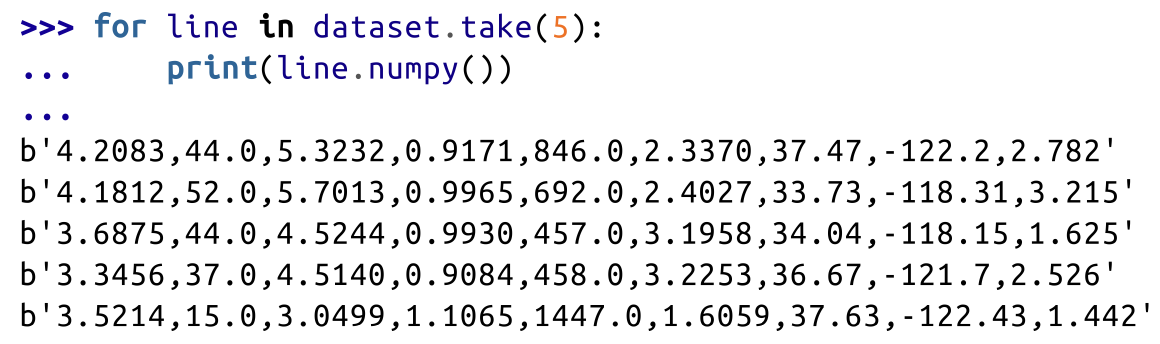

这些是随机选择的 5 个CSV文件的第一行（忽略标题行）。看起来不错！但正如您所看到的，这些只是字节字符串；我们需要解析它们并扩展数据。

### Preprocessing the Data

让我们实现一个小函数来执行此预处理：

```python
X_mean, X_std = [...]
n_inputs = 8

def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

```

让我们浏览一下这个代码：

- 首先，代码假设我们已经预计算了训练集中每个特征的平均值和标准差。 `X_mean` 和 `X_std` 是包含每个输入特征一个的 8 floats 的 1D tensors(或者 NumPy arrays)。
- `preprocess()` 函数取 csv 一行并且解析它开始。 为了这一点， 它使用 `tf.io.decode_csv()` 函数， 其接收 2 个参数： 第一个是要解析的行， 第二个是一个 array 包含 CSV 文件的每列的默认值。该数组不仅告诉 TensorFlow 每列的默认值，还告诉列的数量及其类型。在本例中，我们告诉它，所有特征列都是浮点数，缺失的值应该默认为0，但我们提供了一个类型为最后一列（目标）默认值的空数组：数组告诉TensorFlow，此列包含浮点数，但没有默认值，因此如果遇到丢失的值，它将引发异常。
- `decode_csv()` 函数返回标量张量列表（每列一个），但我们需要返回1D张量数组。所以我们在除最后一个元素外的所有元素的张量上调用`tf.stack()`：这将将这些张量堆叠到一个1D数组中。然后，我们对目标值也这样做（这使得它成为一个具有单个值的1D张量数组，而不是标量张量）。
- 最后，我们通过减去特征平均值来扩展输入特征，然后除以特征标准差，然后我们返回一个包含缩放特征和目标的元组。

让我们来测试这个预处理函数：

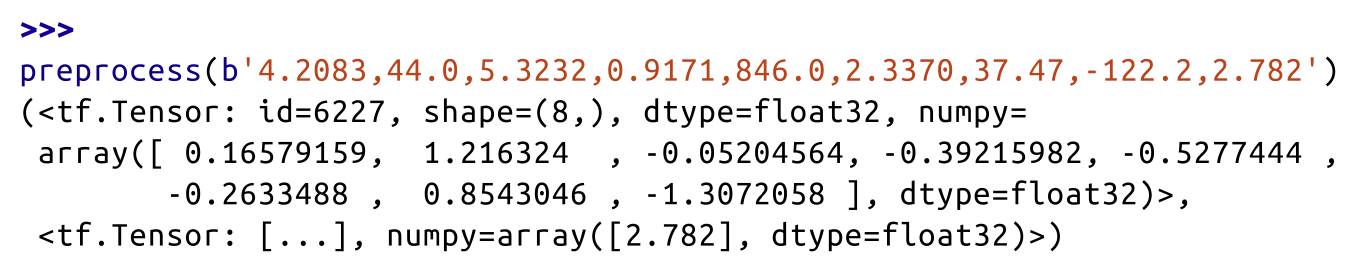

### Putting Everything Together

为了使代码可重用，让我们将迄今为止讨论的所有内容整合到一个 helper 函数中：它将创建并返回一个数据集，该数据集将有效地从多个CSV文件中加载  California housing 数据，对其进行 preprocess it，shuffle，optionally repeat it，并  batch it:

In [9]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5, 
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset = datasets.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_call=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return data.batch(batch_size).prefetch(1)

在这个代码中，除最后一行(`prefetch(1)`)外, 一切清楚，最后一行对性能很重要。

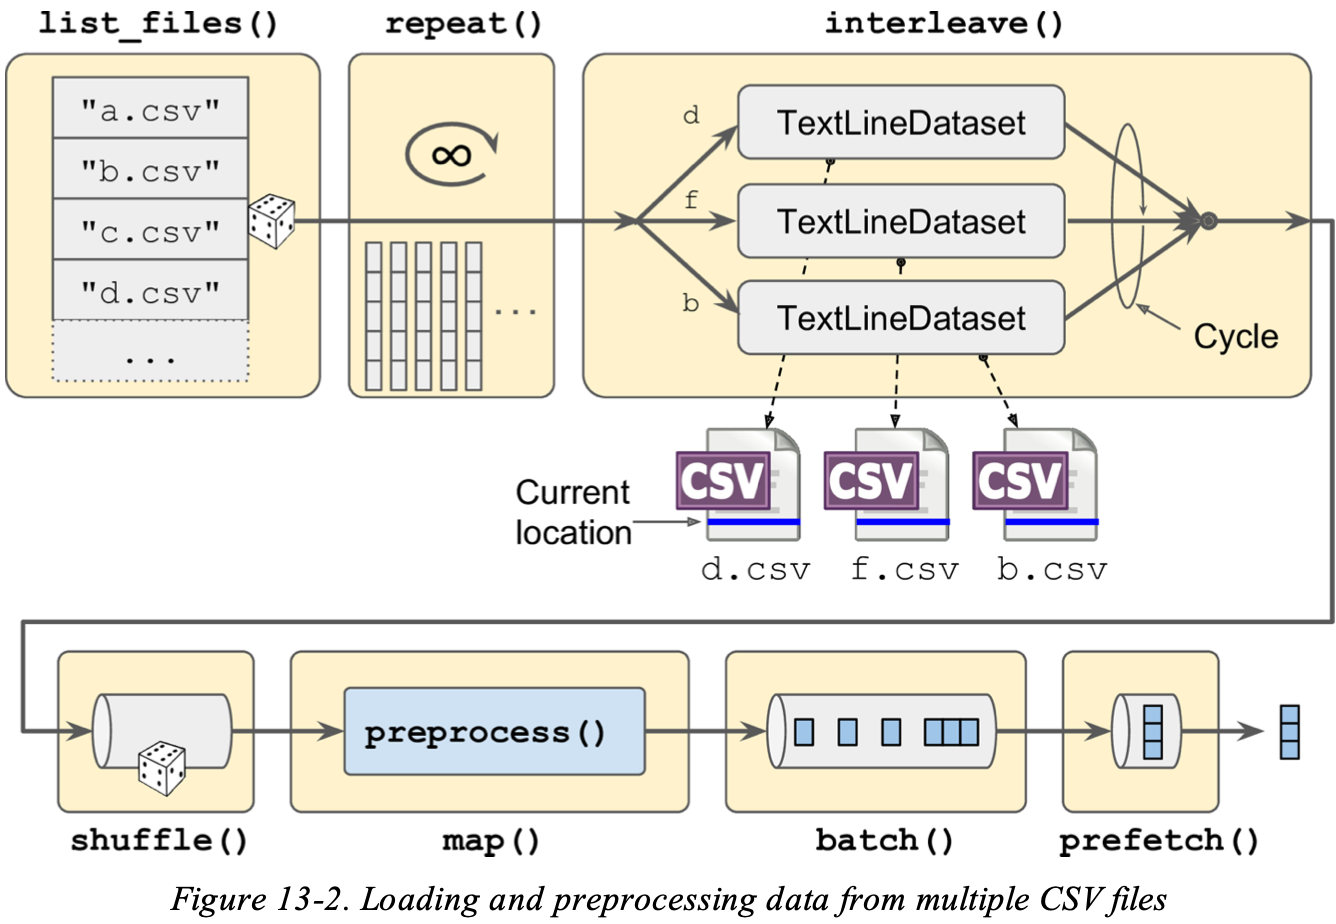

### Prefetching

通过最后调用 `prefetch(1)`，我们正在创建一个 dataset，该 dataset 将尽最大努力始终领先一个 batch。换句话说，当我们的训练算法正在处理一个 batch 时，数据集已经在并行工作，以准备下一个 batch（例如，从磁盘读取数据并对其进行预处理）。这可以显著提高性能，如图13-3所示。如果我们也确保加载和预处理是多线程(当调用 `interleave()` 和 `map()` 通过设置 `num_parallel_calls`)， 我们可以发掘 CPU 的多核心 并且 有可能使准备一批数据比在 GPU 上运行训练一步更时间更短： 这样，GPU将几乎100%得到利用（除了从CPU到GPU3的数据传输时间），训练将运行得更快。

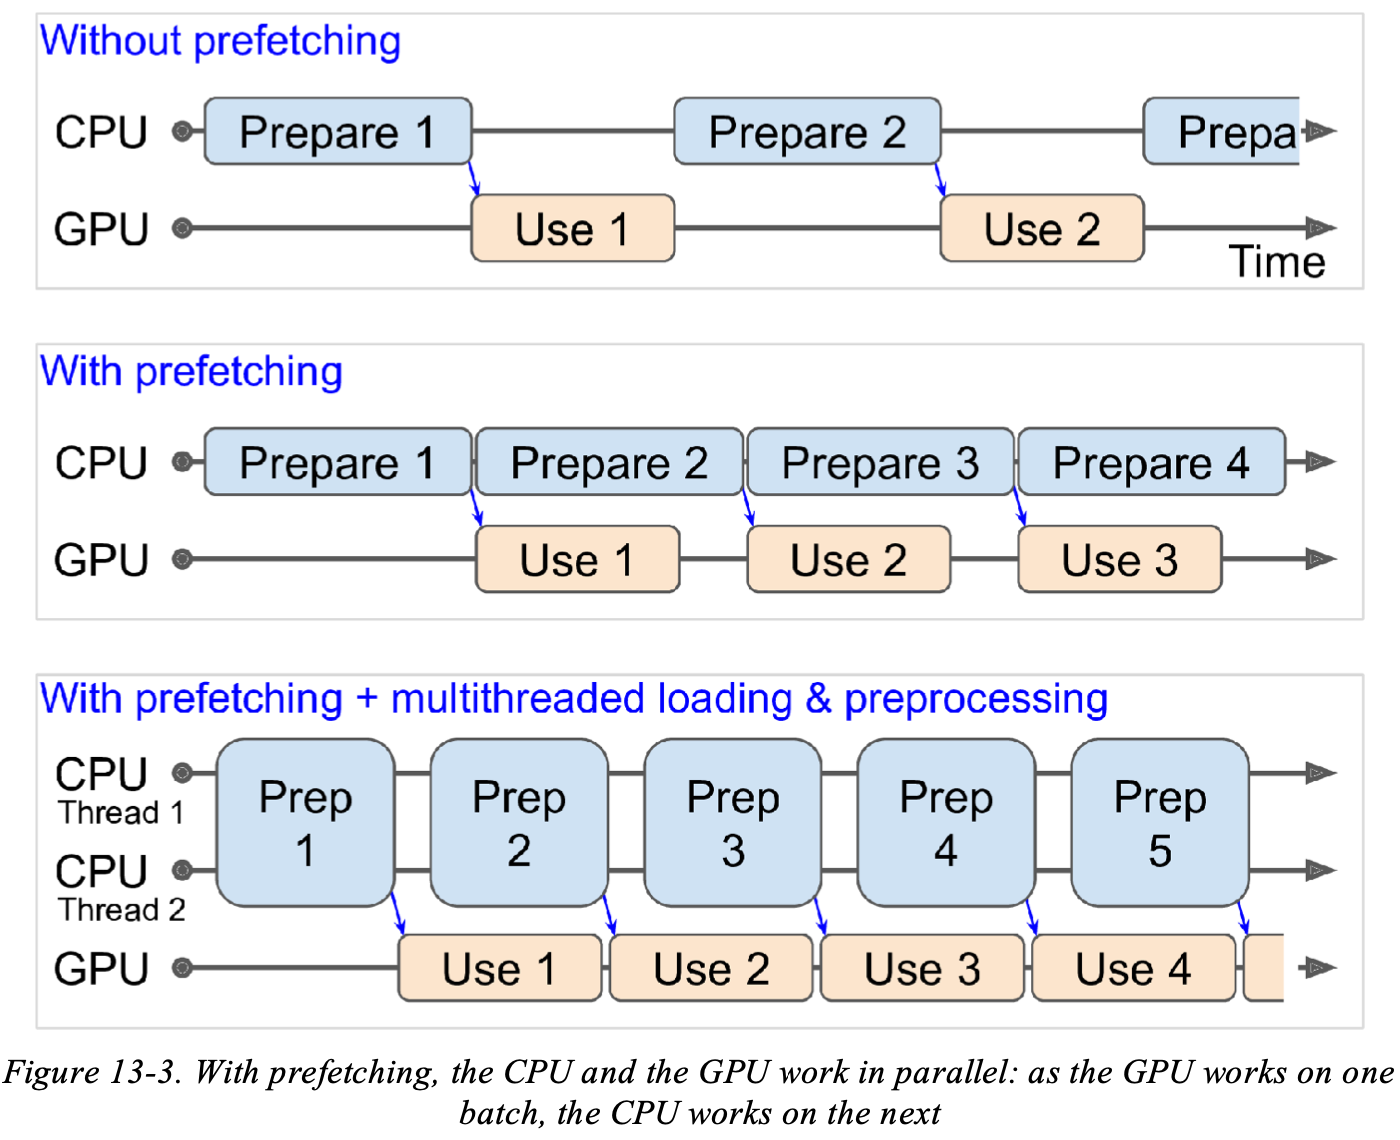

> TIP: 如果您计划购买GPU卡，其处理能力和内存大小当然非常重要（特别是，大的RAM对计算机视觉至关重要）。获得良好性能同样重要的是它的内存带宽；这是它每秒可以进入或离开RAM的 number of gigabytes of data。

如果数据集足够小，可以放在内存，您可以显著加快速度， 通过使用 dataset 的 `cache()` 方法将其内容缓存到RAM来进行训练。您通常应该在 loading 和 preprocessing 后，但在 shuffle、repeat、batching 和 prefetching 之前执行此操作。这样，每个样本只会被 loading 和 preprocess 一次(而不是每个 epoch 一次)， 但数据在每个 epoch 仍将以不同的方式 shuffle，下一批数据仍将提前准备。

您现在知道如何构建高效的 input pipeline 来加载和预处理来自多个文本文件的数据。我们已经讨论了最常见的数据集方法，还有一些其他的方法：`concatenate()`, `zip()`, `window()`, `reduce()`, `shard()`, `flat_map()` 和 `padded_batch()`。 还有几种类方法：`from_generator` 和 `from_tensors()`, 这些创建从 python generator 或 张量列表里创建 dataset。 请检查API文档以获取更多详细信息。另请注意，在 `tf.data.experimental` 有实验性的可用的特性，其中许多可能在未来版本中将其纳入核心API(例如 `CsvDataset` 类 和 `make_csv_dataset()` 方法， 其负责推断每列的类型)

### Using the Dataset with tf.keras

现在，我们可以使用 `csv_reader_dataset()` 函数为训练集创建数据集。请注意，我们不需要重复，因为这将由 `tf.keras` 处理。我们还为验证集和测试集创建数据集：

```python
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)
```

现在，我们可以简单地使用这些数据集构建和训练 Keras 模型。我们只需要将训练和验证数据集传递给 `fit()` 方法，而不是 `X_train`, `y_train`, `X_valid` 和 `y_valid`:

```
model = keras.models.Sequential([...])
model.compile([...])
model.fit(train_set, epochs=10, validation_data=valid_set)
```

相似地， 我们可以传递 dataset 给 `evaluate()` 和 `predict()` 方法：

```
model.evaluate(test_set)
new_set = test_set.take(3).map(lambda X, y: X)
model.predict(new_set)
```

与其他集合不同，这些集合通常不包含标签（如果包含，Keras将忽略它们）。请注意，在所有这些情况下，如果您愿意，您仍然可以使用 NumPy 数组而不是 dataset（但当然，它们需要先 load 和 preprocess ）。

如果您想构建自己的自定义训练循环（如第12章），您可以非常自然地迭代训练集：


```python
for X_batch, y_batch in trainset:
    [...]
```


事实上，甚至可以创建一个TF Function（见第12章），以执行整个训练循环：

```python
@tf.function
def train(model, optimizer, loss_fn, n_epochs, [...]):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, [...])
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
```

恭喜你，你现在知道如何使用 Data API 构建强大的 input pipeline 了！然而，到目前为止，我们已经使用了CSV文件，这些文件常见、简单、方便，但并不真正高效，并且不太支持大型或复杂的数据结构（如图像或音频）。因此，让我们看看如何使用TFRecords。

> TIP: 如果您对CSV文件（或您正在使用的任何其他格式）感到满意，则不必使用TFRecords。俗话说，如果它没有坏，就不要修复它！当训练期间的瓶颈在加载和解析数据时，TFRecord非常有用。

## The TFRecord Format

TFRecord 格式是 TensorFlow 存储大量数据并高效读取的首选格式。它是一种非常简单的二进制格式，仅包含一系列不同大小的二进制记录（每条记录都由长度、检查长度没有损坏的CRC校验和、实际数据以及数据的CRC校验和组成）。你可以使用 `tf.io.TFRecordWriter` 类创建 TFRecord 文件：

In [11]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

你可以使用 `tf.data.TFRecordDataset` 读取一个或多个 TFRecord 文件：

In [12]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


> TIP: 默认情况下，一个 `TFRecordDataset` 将逐个读取文件，但您可以通过设置来使其并行读取多个文件并 interleave 其 records。或者，您可以通过使用 `list_files()` 和 `interleave()` 我们之前所做的那样读取多个CSV文件来获得相同的结果。 

### Compressed TFRecord Files

有时压缩TFRecord文件非常有用，特别是当它们需要通过网络连接加载时。您可以创建通过设置 `options` 参数压缩 TFRecord 文件：

```python
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    [...]
```

读取压缩TFRecord文件时，您需要指定压缩类型：

```python
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
```

### A Brief Introduction to Protocol Buffers

尽管每条记录都可以使用您想要的任何二进制格式，但 TFRecord 文件通常包含 serialized protocol buffers（也称为`protobufs`）。这是一种便携式、可扩展和高效的二进制格式，于2001年在谷歌开发，并于2008年开源； protobufs 现在被广泛使用，特别是在谷歌的远程程序调用系统gRPC中。它们使用一种简单的语言定义，如下所示：

```
syntax = "proto3"
message Person{
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}
```

这个定义说我们正在使用 protobuf 格式的第3版, 它指定每个 `Peroson` 对象有 `string` 类型的 `name`， `int32` 类型的 `id`, 并且 零个或多个 `email` fields， 每个类型为 `string`。 数字 1， 2， 3 是 field identifiers： 他们将用于每个 records 的二进制表示。 一旦你在一个 `.proto` 文件的定义， 你将会编译它。 这需要 `protoc`， protobuf编译器，以Python（或其他语言）生成 access classes。请注意，我们将使用的 protobuf 定义已经为您编译，他们的 Python类是TensorFlow的一部分，因此您不会需要使用 `protoc`。您只需要知道如何在Python中使用protobuf access classes。为了说明基础知识，让我们来看看一个简单的例子， 其使用为 `Person` protobuf 生成的 access classes（代码在注释中解释）：

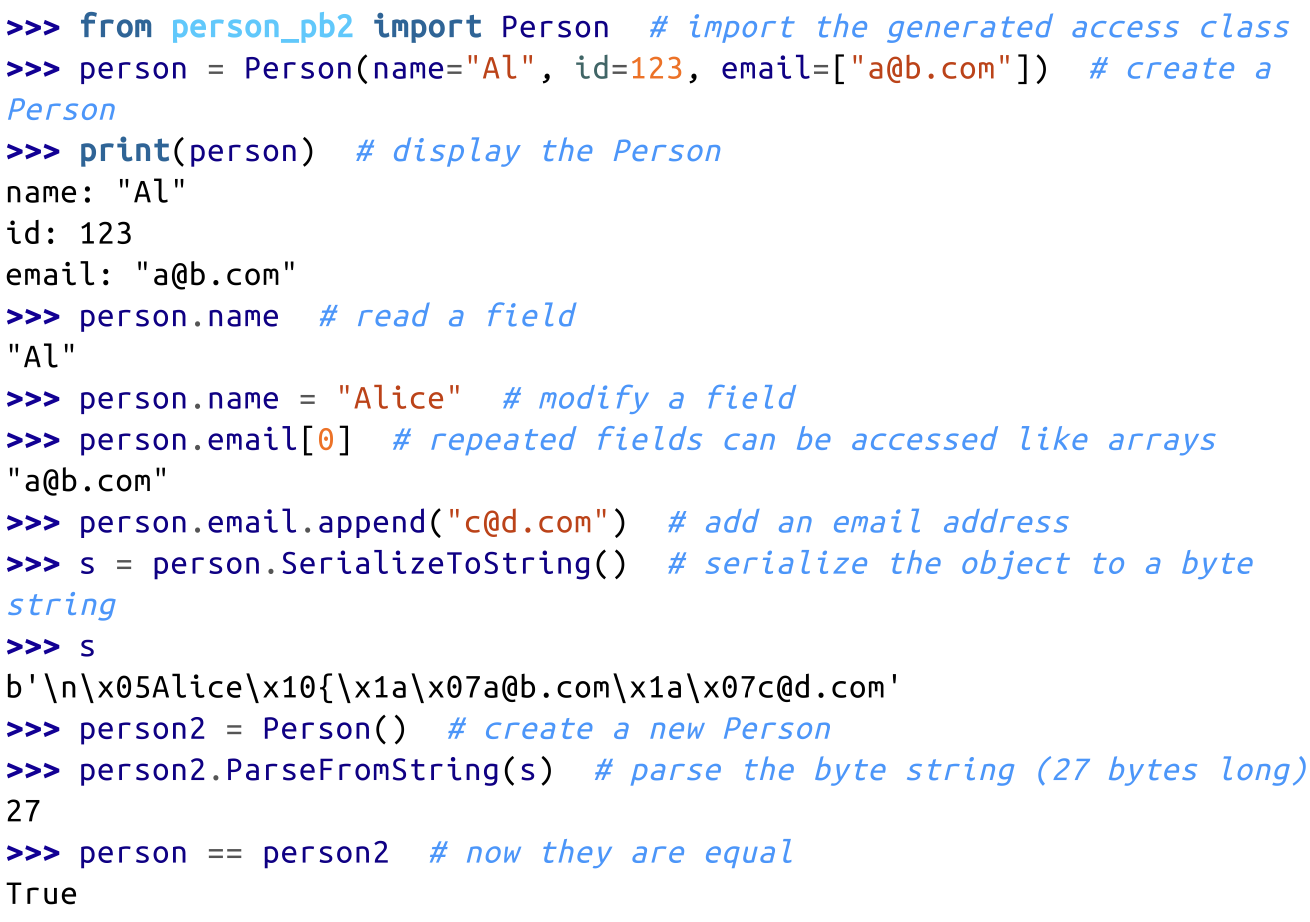

简而言之， 我们导入由 `protoc` 生成的 `Person` 类， 我们创建一个实例， 可视化它并且读取和写入一些 fields, 然后我们使用 `SerializeToString()` 方法序列化它。 这是准备通过网络保存或传输的二进制数据。当读取和接收这个二进制数据时， 我们可以使用 `ParseFromString()` 方法解析它， 并且我们得到序列化的对象的副本。

我们可以保存序列化的 `Person` 对象为 TFRecord 文件， 然后我们可以加载和解析它。 然而 `SerilizeToString` 和 `ParseFromString` 不是 TensorFlow 操作(也不是这个代码的其他操作)， 因此他们不能包含入 TensorFlow Function (除非将它们封装进 `tf.py_function()` 操作， 这会使代码变慢以及更少的可迁移性)。 幸运的是，TensorFlow确实包括特殊的protobuf定义，它为这些定义提供了解析操作。

### TensorFlow Protobufs

在 TFRecord 文件中使用的主要的 protobuf 是 `Example` protobuf, 其表示 dataset 中的一个样本。 它包含一个命名特征列表，其中每个特征可以是 byte strings 列表、floats 列表 或 integers 列表。以下是protobuf的定义：

```
syntax = "proto3";
message BytesList { repeated bytes valie = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

`BytesList`, `FlaotList` 和 `Int64List` 的定义足够直接。 注意到 `[packed = true]` 用于重复 numerical fields, 为了更有效的编码。 `Feature` 包含一个 `BytesList`, 一个 `FloatList`， 或 `Int64List`。 `Features` 包含一个字典， 其映射一个特征名字对应的特征值。 最后， 一个 `Example` 包含一个 `Features` 对象。 这里是如何创建一个 `tf.train.Example` 表示 person 并且 将其写入 TFRecord 文件：

In [16]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }))

代码有点冗长和重复，但它相当简单（您可以轻松地将其包装在一个 helper 函数中）。现在我们有了一个 `Example` protobuf, 我们可以通过调用 `SerializeToString()` 方法序列化它， 然后将结果写入 TFRecord 文件：

In [17]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

通常你会写不止一个 `Example`！通常，您会创建一个从当前格式读取的转换脚本（例如，CSV文件），为每个样本创建一个protobuf，对其进行序列化，并将其保存到多个TFRecord文件中，最好在过程中对其进行 shuffle。这需要一些工作，所以再次确保它确实是必要的（也许您的 pipeline 与 CSV 文件配合得很好）。

现在我们有一个不错的 TFRecord 文件，其中包含一个序列化文件 `Example`，让我们尝试加载它。

### Loading and Parsing Examples

为了加载序列化的 `Example` protobufs， 我们将再次使用 `tf.data.TFRecordDataset`， 我们将使用 `tf.io.parse_single_example()` 解析每个 `Example`。 这是一个TensorFlow操作，因此可以包含在 TF 函数中。它至少需要两个参数：包含序列化数据的 字符串标量张量，以及每个特征的描述。描述是一个字典， 其映射每个特征名字到一个 `tf.io.FixedLenFeature` 描述子， 其表示特征的形状， 类型 和 默认值， 或者一个 `tf.io.VarLenFeature` 描述子仅表示类型(如果特征的列表长度可变， 例如 "emails" 特征)。

接下来的代码定义一个描述字典，然后它在 `TFRecordDataset` 迭代 并且 解析序列化的 `Example` protobuf：


In [19]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)

固定长度特征被解析为 regular 张量，但可变长度特征被解析为 sparse 张量。 你可以使用 `tf.sparse.to_dense()`转换 sparse 张量为 dense 张量， 但是在这个例子中得到它的值更简单：

In [20]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [21]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

`ByteList` 可以包含你想要的任一二进制数据， 包括任一序列化的对象。例如， 你可以使用 `tf.io.encode_jpeg()` 来使用 JPEG 格式编码图像 并且 将这个二进制数据放到 `ByteList`。 然后， 当你的代码读取 TFRecord, 它会开始解析 `Example`， 然后它将需要调用 `tf.io.decode_jpeg()` 以解析数据并且得到原始图像(或者你可以使用 `tf.io.decode_image()`, 其可以解码任意 BMP， GIF， JPEG 或 PNG 图像)。 你也可以存储你想要的任意张量到一个 `BytesList` 中， 通过使用 `tf.io.serialize_tensor` 序列化张量， 然后将结果 byte string 放到 BytesList 特征。然后 ，当你解析TFRecord， 你可以使用 `tf.io.parse_tensor()` 解析这个数据。 相比于使用 `tf.io.parse_single_example()` 解析样本， 你可能想要通过使用 `tf.io.parse_example()` 方法批量解析它们。

In [22]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples, feature_description)

如你所见， `Example` protobuf 在大多数使用情况足够有效。 然而，当您处理列表的列表时，使用起来可能有点麻烦。例如，假设您想对文本文档进行分类。每个文档都可以表示为句子列表，其中每个句子都可以表示为单词列表。也许每个文档也有一个评论列表，其中每个评论都表示为单词列表。也可能会有上下文数据， 例如文档作者， 标题和出版日期。 TensorFlow 的 `SequenceExample` protobuf 用于这种情况。

### Handling Lists of Lists Using the SequenceExample Protobuf

这里是 `SequenceExample` protobuf 的定义：

```
message FeatureLsit { repeated Feature feature = 1; }
message FeatureLists { map<string, FeatureList> feature_list = 1; }
message SequenceExample {
    Feature context = 1;
    FeatureLists feature_lists = 2;
```

`SequenceExample` 包含一个 `Features` 对象用于上下文数据， 一个 `FeatureLists` 对象包含一个或多个叫做 `FeatureList` 的对象(例如， 一个 `FeatureList` 被命名为 "content", 另一个被命名为 "comments")。 每个 `FeatureList` 包含一组 `Feature` 对象， 每个 `Feature` 对象可能是 byte string 的列表， 64-bit integers 的列表， 或者 floats 的列表(在这个例子中， 每个 `Feature` 将表示一个句子或一个评论， 也许是表示 word identifiers 的列表)。 建立一个 `SequenceExample`, 序列化它， 并且解析塔与建立、序列化和解析一个 `Example` 类似， 但是你必须使用 `tf.io.parse_single_sequence_example()` 解析单个 `SequenceExample` 或 `tf.io.parse_sequence_examplt()` 解析 batch。 这两个函数都返回一个包含上下文特征（作为字典）和特征列表（也作为字典）的元组。如果特征列表包含不同大小的序列（如上一个例子），您可能希望将它们转换为 ragged 的张量，使用 `tf.RaggedTensor.from_sparse()`:

```python
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_list["content"])
```

现在您已经知道如何高效地存储、加载和解析数据，下一步是准备数据，以便将其输入到神经网络。

## Preprocessing the Input Features

为神经网络准备数据需要将所有特征转换为数字特征，通常对其进行规范化等。特别是，如果您的数据包含类别特征或文本特征，则需要将其转换为数字。这可以在准备数据文件时提前完成，使用您喜欢的任何工具（例如NumPy、pandas 或 Scikit-Learn)。 或者，您可以随时预处理数据，当使用 Data API 加载它(例如， 使用 dataset 的 `map()` 方法，像我们之前看到的)， 或者你可以直接在你的模型中包含一个 preprocessing layer。

例如，以下是你可以如何使用使用 `Lambda` layer 实现 standardization layer。对于每个特征，它减去平均值并除以其标准差（加上一个微小的平滑项，以避免除以零）：

```python
means = np.mean(X_train, axis=0, keepdims=True)
stds = np.std(X_train, axis=0, keepdims=True)
eps = keras.backend.epsilon()
model = keras.models.Sequential([
    keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps)),
    [...]
])
```

这不太难！但是，您可能更喜欢使用漂亮的 self-contained custom layer（非常类似于Scikit-Learn的 `StandardScalaer`），而不是像 `means` 和 `stds` 的全局变量：

In [25]:
from tensorflow import keras
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_+ keras.backend.epsilon())

在使用此 standardization layer，您需要通过调用 `adapt()` 方法 adapt it 并传递它到数据样本。这将允许它为每个特征使用适当的平均值和标准差：

```python
std_layer = Standardization()
std_layer.adapt(data_sample)
```

此示例必须足够大，以代表您的数据集，但它不必是完整的训练集：一般来说，数百个随机选择的样本就足够了（然而，这取决于您的任务）。接下来，您可以像普通层一样使用此预处理层：

```python
model = keras.Sequential()
model.add(std_layer)
[...]
model.compile([...])
model.fit([...])
```

如果您认为Keras应该包含像这样的标准化层，这里有一些好消息供您参考：当你读到这里的时候， `keras.layers.Normalization` 层可能已经可用了。 它和自定义的 `Standardization` 层非常相似： 首先， 创建层， 然后通过将样本传入 `adapt()` 方法 adapt 你的数据集， 最终使用该层规范化。

现在，让我们来看看 categorical features。我们将首先将它们编码为 one-hot 向量。

### Encoding Categorical Features Using One-Hot Vectors

考虑一下我们在第二章中探索的 California housing dataset 中的 `ocean_proximity` 特征：这是一个 categorical 特征， 其有 5 个可能值： "<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY" 和 "ISLAND"。 在将此特征输入到神经网络之前，我们需要对其进行编码。由于类别很少，我们可以使用 One-hot 编码。为此，我们首先需要将每个 category 映射到其 index（0到4），这可以使用查找表完成：

In [29]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

让我们浏览一下这个代码：

- 我们首先定义 `vocabulary`：这是所有可能类别的列表。
- 然后，我们创建一个具有相应索引(0到4)的张量。
- 接下来，我们为 lookup table 创建一个 initializer，传递类别列表及其相应的索引。在这个例子中， 我们已经有了这个数据， 因此我们使用一个 `KeyValueTensorInitializer`; 但是如果 categories 列在文本文件中（每行一个类别），我们将使用 `TextFileIntializer` 代替。
- 在最后两行中，我们创建 lookup table，给它 initializer 并指定 out-of-vocabulary (oov) bucket 的数量。如果我们  lookup table  中不存在的类别， lookup table 将计算该类别的哈希值，并使用它来将未知类别分配给其中一个oov buckets。它们的索引从已知类别之后开始，因此在本例中，两个oov buckets 的索引为5和6。

为什么要使用 oov buckets？好吧，如果类别数量很大（例如邮政编码、城市、单词、产品或用户），并且数据集也很大，或者它一直在变化，那么获得完整的类别列表可能不是方便的。 一个解决方案是根据数据样本（而不是整个训练集）定义词汇表，并为数据样本中没有的其他类别添加一些oov bucket。您期望在训练期间发现的未知类别越多，您应该使用的 oov bucket 就越多。事实上，如果没有足够的oov bucket，就会发生碰撞：不同的类别最终会出现在同一个 bucket 中，因此神经网络将无法区分它们（至少不是基于此特征）。

现在，让我们使用 lookup table 将一小批 categorical 特征编码为 one-hot 向量：

In [30]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [32]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

如你所见， `"NEAR BAY"` 被映射为索引 3， 未知的类别 `"DESERT"` 被映射为两个 oov buckets 之一(索引5)， 并且 `"DESERT"` 被映射为索引 1 两次。然后我们使用 `tf.one_hot()` 编码这些索引， 等于 vocabulary size 加上 oov buckets 的数量。现在，您知道如何使用 TensorFlow 将分类功能编码为 one-hot 向量！

就像之前一样，将所有这些逻辑写成一个 self-contained class 并不难。 它的 `adapt()` 方法接收数据样本 并且 提取它包含的所有类别。 它将创建一个查找表，将每个类别映射到其索引（包括未知类别， 使用oov bucket）。然后它的 `call()` 方法使用查找表映射类别为索引。 好吧，这里有更多好消息：当你读到这篇文章时，Keras可能会包括一个名为 `keras.layer.TextVectorization`， 其能够做同样的事： 它的 `adapt()`方法抽取数据样本中的 vocabulary， 它的 `call()` 方法将每个类别转换为 vocabulary 中的索引。 你可以添加这个层到你的模型的开始， 在一个 `Lambda` 层之后， 其应用 `tf.one_hot()` 函数， 如果你想要转换这些索引为 one-hot 向量。

不过，这可能不是最好的解决方案。每个 one-hot 向量的大小是 vocabulary length 加上 oov bucket 的数量。当只有几个可能的类别时，这很好，但如果 vocabulary 很大，改用 `embeddings` 来编码它们会高效得多。

> TIP: 根据经验，如果类别数量低于10个，那么 one-hot 编码是一种可行的方法。如果类别数量大于50（使用哈希桶时通常如此），那么 `embeddings` 通常更可取。在10到50个类别中，您可能需要尝试这两个选项，看看哪个最适合您的数据。


## Encoding Categorical Features Using Embeddings

`embedding` 是表示类别的可训练稠密向量。 默认情况下，`embedding` 是随机初始化的， 例如 `"NEAR BAY"` 类别可以初始表示为一个如 `[0.131, 0.890]` 的向量， 而 `"NEAR OCEAN"` 类别可能表示为另一个如 `[0.631, 0.791]` 的随机向量。 在这个例子中，我们使用2D嵌入，但维度数是一个可以调整的超参数。由于这些 `embeddings` 是可训练的，它们在训练过程中会逐渐改善；由于它们代表着相当相似的类别，梯度下降最终肯定会将它们推得更紧密，而往往会使它们远离 `"INLAND"` 类别的 embedding。 事实上，表示得越好，神经网络就越容易做出准确的预测，因此训练往往使 `embeddings` 有意义的类别表示。这叫作 `representation learning`。

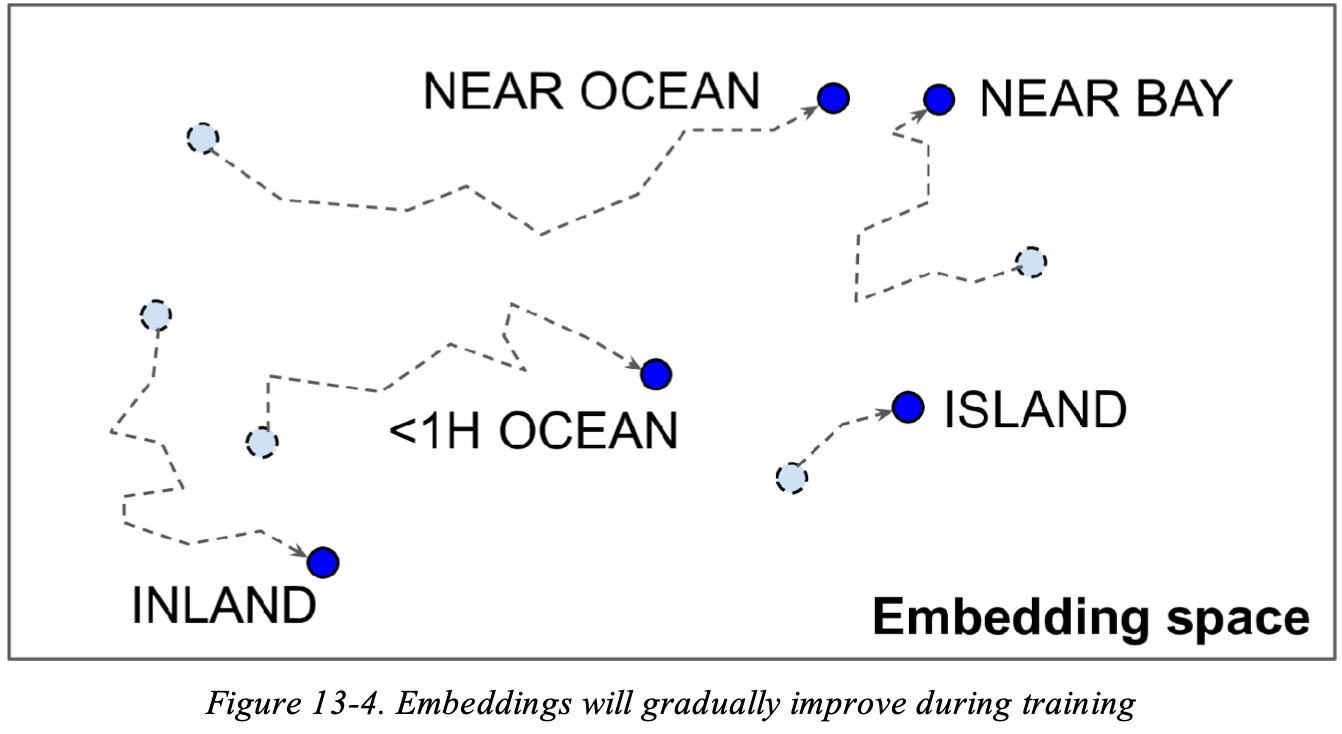

> WORD EMBEDDINGS: `embeddings` 不仅通常是手头任务的有用表示，而且通常这些相同的 `embeddings` 可以成功重用到其他任务中。最常见的例子是 `word embeddings`（即单个单词的 embeddings）：当您处理自然语言处理任务时，通常最好重复使用预训练的 word embeddings，而不是训练自己的 word embeddings。
>
> 使用向量表示单词的想法可以追溯到20世纪60年代，许多复杂的技术被用来生成有用的向量，包括使用神经网络。但事情确实在2013年起飞了，当时Tomáš Mikolov和其他谷歌研究人员发表了一篇论文，描述了使用神经网络学习 word embeddings 的有效技术，明显优于之前的尝试。这使他们能够学习在非常大的文本语料库上的 embeddings：他们训练了一个神经网络来预测任何给定单词附近的单词，并获得惊人的 word embeddings。例如，同义词的 embeddings 非常接近，法国、西班牙和意大利等语义相关的单词最终聚集在一起。
>
> 然而，这不仅仅是接近：word embeddings 也沿着 embeddings 空间中组织有意义的轴。这里有一个著名的例子：如果你计算King – Man + Woman（添加和减去这些单词的 embeddings 向量），那么结果将非常接近单词 Queen 的 embeddings（见图13-5）。换句话说，word embeddings 编码了性别的概念！同样，你可以计算 Madrid – Spain + France,，结果离 Paris 很近，这似乎表明首都的概念也编码在 embeddings 中。
>
> 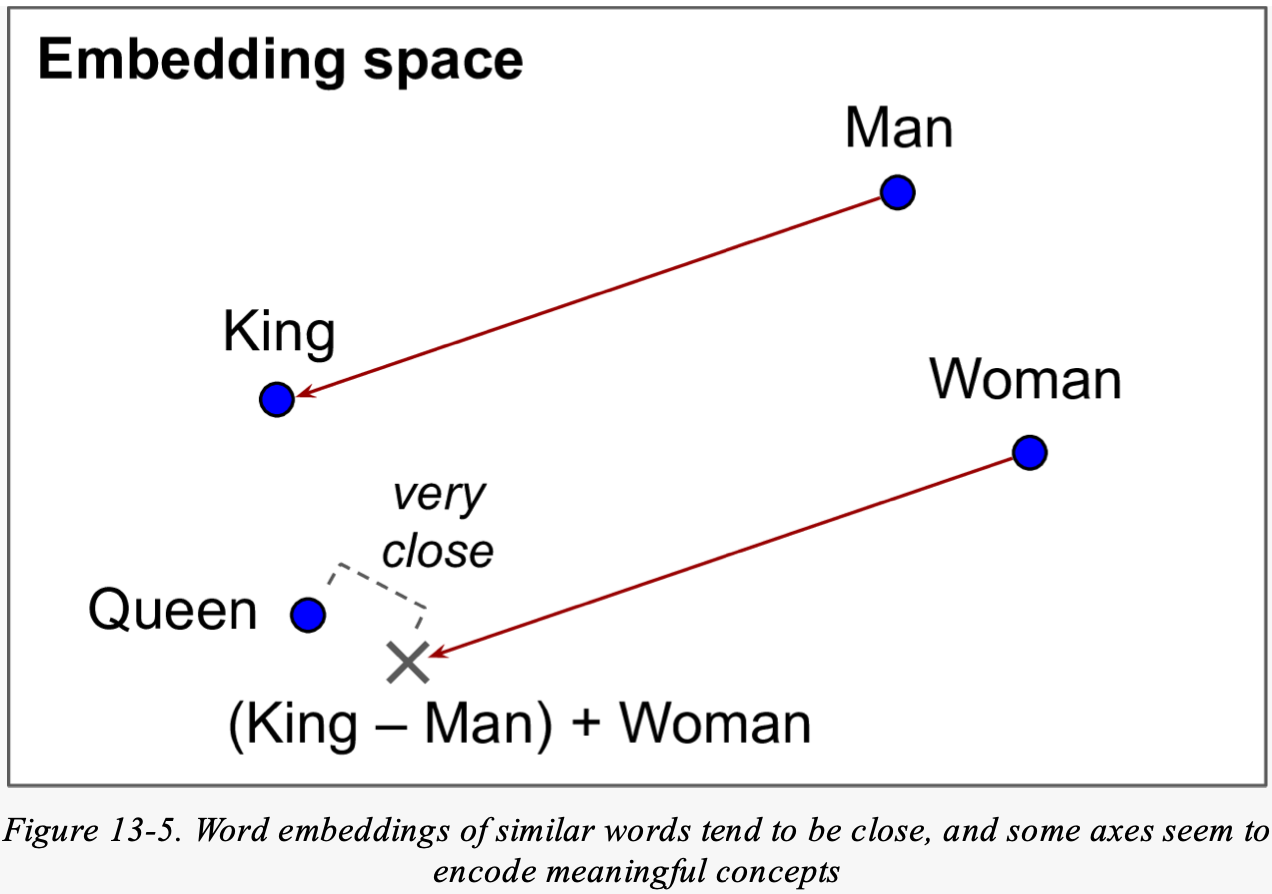
>
> 不幸的是，word embeddings 有时会捕捉到我们的偏见。例如，尽管他们正确地了解到男人对国王就像女人对女王一样，但他们似乎也了解到男人对医生就像女人对护士一样：性别歧视的偏见！公平地说，正如Malvina Nissim等人在2019年的一篇论文中指出的那样，这个特定的例子可能被夸大了。然而，确保深度学习算法的公平性是一个重要而活跃的研究课题。


让我们看看如何手动实现 embeddings ，以了解它们的工作原理（然后我们将使用一个简单的 Keras 层）。首先，我们需要创建一个包含每个类别嵌入的 embeddings 矩阵，随机初始化；它每个 category 和每个 oov bucket 将有一行，每个 embedding 维度将有一列：

In [33]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

在本例中，我们正在使用2D embeddings，但根据经验，embeddings 通常有10到300个维度，具体取决于任务和 vocabulary 大小（您必须调整此超参数）。

此 embeddings 矩阵是一个随机的 6×2 矩阵，存储在变量中（因此在训练期间可以通过梯度下降对其进行调整）：

In [34]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.23262191, 0.32542896],
       [0.83341074, 0.1912924 ],
       [0.8609984 , 0.7757752 ],
       [0.9354265 , 0.7662864 ],
       [0.33599234, 0.76887405],
       [0.11287344, 0.20944619],
       [0.05991471, 0.02968168]], dtype=float32)>

现在，让我们对类别特征进行编码，但这次使用这些 embeddings：

In [36]:
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

`tf.nn.embedding_lookup()` 函数在给定的索引处查找 embedding matrix 中的行——这就是它所做的一切。例如， 查找表 `"INLAND"` 类别对应索引 1， 因此 `tf.nn.embedding_lookup()` 函数返回 embedding matrix 第一行的 embedding: `[0.3528825, 0.46448255]`。

Keras 提供一个 `keras.layers.Emebdding` 层处理 mebedding matrix(默认是可训练的)； 当创建 layer 时，它会随机初始化 embedding 矩阵，然后当它调用一些类别索引时， 他返回在 `embedding matrix` 这些索引对应的行。

In [38]:
embedding = keras.layers.Embedding(input_dim=len(vocab)+num_oov_buckets, output_dim=embedding_dim)
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.04354265,  0.02662864],
       [-0.03871266, -0.02905538],
       [ 0.03334108, -0.03087076],
       [ 0.03334108, -0.03087076]], dtype=float32)>

将所有内容放在一起，我们现在可以创建一个Keras模型，该模型可以处理类别特征（以及 regular numerical 特征），并学习每个类别（以及每个oov bucket）的 embedding：

In [42]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories], 
                           outputs=[outputs])

该模型需要两个输入：每个样本包含 8 个 numerical features 的 regular input，外加一个 categorical input（一个类别包含一个类别特征）。它使用一个层来查找每个类别的索引，然后查找这些索引的 `embeddings`。接下来，它将 `embeddings` 和 regular input 连接起来，以便提供编码输入，这些输入已准备好输入到神经网络。此时，我们可以添加任何类型的神经网络，但我们只是添加一个密集的输出层，然后我们创建了 Keras 模型。


当 `keras.layers.TextVectorization` 层可用时， 你可以调用 `adapt()` 方法从数据中提取 vocabulary(它将负责为您创建查找表)。 然后，您可以将其添加到模型中，它将执行索引查找（替换上一个代码示例中的 `Lambda` 层）。 

> NOTE： One-hot 编码后跟一个 `Dense` 层(不带激活函数和 bias) 等价于 `Embedding` 层。 然而， `Embedding` 层使用更少的计算量(性能差异在 embedding matrix 变大时变得明显)。 `Dense` 层的权重矩阵扮演 mebdding matrix 的角色。 例如， 使用大小为 20 的 one-hot 向量 和 一个带有 10 个单元的 `Dense` 层 等价于 `input_dim=20` 和 `output_dim=10` 的 `Embedding` 层。 因此， 使用多于在 `Embedding` 层后的层的单元数量的 embedding 维度是浪费的。


现在让我们更仔细地看看 Keras  preprocessing layers 。

### Keras Preprocessing Layers

TensorFlow 提供一组标准 Keras preprocessing layers。 在您阅读这篇文章时，它们可能会可用；但是，到那时API可能会略有变化。这个新API可能会取代现有的Feature Columns API，Feature Columns API更难使用，也不那么直观。

我们已经讨论过这些层的两个： `keras.layers.Normalization` 层执行特征标准化(它等价于之前定义的 `Standardization` 层)， `TextVectorization` 能够编码每个次为其在 vocabulary 中的索引。 这两种情况下， 你可以创建层， 对数据调用 `adapt()` 方法， 然后您在模型中正常使用该层。其他预处理层将遵循相同的模式。

包括 `keras.layers.Discretization` 层将连续数据切成不同的 bin ，并将每个 bin 编码为一个 one-hot 向量。例如，您可以使用它将价格分为三类（低、中、高），分别编码为[1、0、0]、[0、1、0]和[0、0、1]。当然，这会丢失很多信息，但在某些情况下，它可以帮助模型检测模式，否则这些模式在仅仅查看连续值时不会明显。

> Discretization 层是不可微的， 因此它应该是你模型的开始。 事实上，模型的预处理层将在训练期间冻结，因此其参数不会受到梯度下降的影响，因此它们不需要可微。这也意味着你不应该直接使用 `Embedding` 层到一个自定义 preprocessing 层中， 如果你想它可训练： 相反，它应该单独添加到您的模型中，就像之前的代码示例一样。

使用 `PreprocessingStage` 类 链接多个 preprocessing 层也是可能的。 例如，以下代码将创建一个preprocess pipeline，首先规范输入，然后离散化它们（这可能会让您想起 Scikit-Learn pipeline ）。将此 pipeline adapt 数据样本后，您可以像模型中的常规层一样使用它（但同样，仅在模型开始时，因为它包含一个不可微分的预处理层）：

```python
normalization = keras.layers.Normalization()
discretization = keras.layers.Discretization([...])
pipeline = keras.layers.PreprocessingStage([normalization, discretization])
pipeline.adapt(data_sample)
```

`TextVectorization` 层也有一个选项输出 word-count 向量而不是 word indices。 例如，如果 vocabulary 包含 3 个词 `["and", "basketball", "more"]`， 然后文本 "more and more" 将会被映射为向量 `[1, 0, 2]`：  `"and"`出现 1 次， 词 `"basketball"` 没有出现， `"more"`出现两次。 这个文本表征叫做 `bag of the word`， 因为它丢失了词的顺序。 通常像 `"and"` 词在大部分的文本中大量出现。 即便我们通常不是很关心它们。因此，单词计数应该标准化，以降低频繁出现单词的重要性。一种常见的方法是将每个单词计数除以单词出现的训练样本总数的对数。这种技术叫做 `Term-Frequency x Inverse-Document-Frequency`(TF-IDF)。 例如， 让我们假设词 "and", "basketball" 和 "more" 在训练集中分别出现 200, 10 和 100 个文本样本： 在这个例子中， 最终的向量将会是 `[1/log(200), 0/log(10), 2/log(100)]`， 大概等于 `[0.19, 0., 0.43]`。 `TextVecorization` 层有选项可以执行 TF-IDF。

> NOTE: 如果 standard preprocessing layers 对你的任务不足够， 你仍然有选项创建自己的自定义 preprocessing layer， 像我们之前定义的 `Standardization` 类一样、 创建 `keras.layers.PreprocessingLayer` 的子类，其带有一个 `adapt()` 方法， 接收 `data_samplt` 参数并且可选使用额外的 `reset_state` 参数： 如果为 `True`, `adapt()` 方法在计算新的状态之前重置现有状态； 如果为 `False`， 他应该更新现有状态。

如您所见，这些Keras预处理层将使预处理变得容易得多！现在，无论您是选择编写自己的预处理层还是使用Keras（甚至使用Feature Columns API），所有预处理都将实时完成。在训练期间可能更倾向于提前完成预处理， 让我们看看为什么我们想要这么做以及如何这么做。

## TF Transform

如果预处理在计算上很昂贵，那么在训练前而不是在训练中处理它可能会大大加快速度：在训练前，数据将每个样本只预处理一次，而不是在训练期间每个样本和每个 epoch 预处理一次。如前所述，如果数据集足够小，可以放入RAM，您可以使用它的 `.cache()` 方法。但如果它太大，那么 Apache Beam 或 Spark 等工具会有所帮助。它们允许您在大量数据上运行高效的 data processing pipelines，甚至分布在多台服务器上，因此您可以在训练前使用它们进行所有训练数据的预处理。

这效果很好，确实可以加快培训速度，但有一个问题：一旦您的模型经过训练，假设您想将其部署到移动应用程序中。在这种情况下，您需要在应用程序中编写一些代码，以便在数据输入模型之前对其进行预处理。假设您还想将模型部署到 TensorFlow.js，以便在网络浏览器中运行？再次，您需要编写一些预处理代码。这可能会成为维护噩梦：每当您想更改预处理逻辑时，您需要更新Apache Beam 代码、移动应用程序代码和 JavaScript 代码。这不仅耗时，而且容易出错：训练前执行的预处理操作与在应用程序或浏览器中执行的预处理操作之间可能会有细微的差异。这种训练/服务偏差将导致错误或性能下降。

一个改进是采用训练好的模型（根据 Apache Beam 或 Spark 代码预处理的数据进行训练），并在将其部署到应用程序或浏览器之前，添加额外的预处理层，以实时处理预处理。这绝对更好，因为现在您只有两个版本的预处理代码：Apache Beam 或 Spark代码，以及预处理层的代码。 

但是，如果您可以只定义一次预处理操作呢？这就是TF Transform的设计目的。它是TensorFlow Extended（TFX）的一部分，TensorFlow Extended 是一个生产 TensorFlow 模型的端到端平台。首先，要使用 TF Transform 等 TFX 组件，您必须安装它；它不与 TensorFlow 捆绑。然后，您只需定义一次预处理函数（在Python中），使用 TF Transform 函数进行scaling, bucketizing 等。您还可以使用任何您需要的 TensorFlow 操作。如果我们只有两个特征，这个预处理功能可能会是什么样子：

In [43]:
import tensorflow_transform as tft

def preprocess(inputs):
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age)
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age": standardized_age,
        "ocean_proximity_id": ocean_proximity_id
    }

ModuleNotFoundError: No module named 'tensorflow_transform'

接下来， TF Transform 使用 Apache Beam 让你 apply 这个 `preprocess()` 函数到整个训练集上 (它提供一个 `AnalyzeAndTransformDataset` 类可以在你的 Apache Beam pipeline 里用作这个目的)。 在 process 中， 它将对整个训练集计算所有必要的数据：在这个例子中， `housing_median_age` 特征的 均值 和 标准差， 以及用于 `ocean_proximity` 特征的 vocabulary。 用于计算这些数据的组件叫做 `analyzers`。

重要的是，TF Transform 还将生成一个等效的 TensorFlow Function，您可以将其插入部署的模型中。这个 TF Function 包括一些常量，这些常量对应于 Apache Beam 计算的所有必要统计数据（平均值、标准差和 vocabulary）。

使用 Data API、TFRecords、Keras preprocessing layers 和 TF Transform，您可以构建高度可扩展的输入管道进行训练，并从生产中的快速可迁移数据预处理中受益。

但是，如果您只想使用标准数据集呢？好吧，在这种情况下，事情要简单得多：只需使用TFDS！

## The TensorFlow Datasets (TFDS) Project

TensorFlow Datasets 项目可以非常轻松地下载常见的数据集，从 MNIST 或 Fashion MNIST 等小型数据集到 ImageNet 等大型数据集（您需要相当多的磁盘空间！）。该列表包括图像数据集、文本数据集（包括翻译数据集）以及音频和视频数据集。您可以访问 [https://homl.info/tfds](https://homl.info/tfds) 查看完整列表，以及每个数据集的描述。

TFDS 没有绑定在 TensorFlow， 因此你需要安装 `tensorflow-dataset` 库。 然后调用 `tfds.load()` 函数， 它将下载您想要的数据（除非之前已经下载），并将数据作为数据集字典返回（通常用于训练，一个用于测试，但这取决于您选择的数据集）。例如，让我们下载MNIST：

In [44]:
from tensorflow_datasets as tfds

dataset = tfds.load(name="mnist")
mnist_train, mnist_test = dataset["train"], dataset["test"]

SyntaxError: invalid syntax (4277001705.py, line 1)

然后，您可以应用您想要的任何 transformation（通常是 shuffling、batching 和 prefetching），并且您就可以训练您的模型了。以下是一个简单的例子：

```python
mnist_train = mnist_train.shuffle(10000).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    [...]
```

> TIP: `load()` 函数打乱每个数据， 并且下载每个数据碎片（仅训练集）。这可能还不够，所以最好再 shuffle 一些训练数据。

请注意，dataset 中的每个项都是包含 特征 和 标签 的字典。但 Keras 希望每个项都是包含两个元素（同样是特征和标签）的元组。你可以使用 `map()` 方法转换数据集，如下所示：

```python
mnsit_train = mnist_train.shuffle(10000).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
```

但是更简单的方法是通过在 `load()` 函数中设置 `as_supervised=True`。 如果您愿意，您还可以指定批大小。然后，您可以通过 dataset 直接发送到您的 tf.keras 模型：

```python
dataset = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = dataset["train"].prefetch(1)
model = keras.models.Sequential([...])
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd")
model.fit(mnist_train, epochs=5)
```

这是一个相当技术性的一章，你可能会觉得它与神经网络的抽象美有点远，但事实是深度学习通常涉及大量数据，知道如何高效地加载、解析和预处理数据是一项至关重要的技能。在下一章中，我们将研究卷积神经网络，它们是图像处理和许多其他应用中最成功的神经网络架构之一。

## Exercises

- 为什么你想要使用 Data API ?
- 将大型数据集拆分为多个文件有什么好处？
- 在训练期间，您如何判断您的输入 pipeline 是瓶颈？你能做些什么来修复它？ 
- 您可以将任何二进制数据保存到 TFRecord 文件中，还是只能保存序列化协议缓冲区？
- 你为什么将所有数据转换为 `Examplt` protobuf 格式？ 为什么不使用你自己的 protobuf 定义？
- 使用TFRecords时，您想什么时候激活压缩？为什么不系统地做呢？
- 在编写数据文件时，或在 tf.data pipeline 中，或在模型中的预处理层或使用 TF Transform 时，可以直接进行预处理。你能列出每个选项的优点和缺点吗？
- 说出一些可用于编码 categorical 特征的常见技巧。文本呢？
- 加载 Fashion MNIST 数据集；将其拆分为训练集、验证集和测试集； shuffle 训练集；并将每个数据集保存到多个 TFRecord 文件中。每个 record 应该被序列化为有两个特征的 `Example` protobuf： 序列化的图像(使用 `tf.io.serialize_tensor()`) 和标签。 然后使用 `tf.data` 为每个集创建一个高效的 dataset。 最后，使用 Keras 模型来训练这些数据集，包括一个预处理层来标准化每个输入特征。尝试使输入 pipeline 尽可能高效，使用 TensorBoard 可视化分析数据。
- 在这个练习中你将下载数据集， 拆分它， 创建一个 `tf.data.Dataset` 加载它并且高效地预处理它， 然后建立和训练一个带有 `Embedding` 层的二分类模型。
- - 下载 Large Movie Review Dataset，其中包含来自互联网电影数据库的50,000条电影评论。数据分为两个目录，训练和测试，每个目录都包含一个有12,500条 正面评论的 pos 子目录和一个有 12,500 条负面评论的 neg 子目录。每个评论都存储在一个单独的文本文件中。还有其他文件和文件夹（包括预处理的 bag-of-words），但我们将在本练习中忽略它们。
- - 将测试集拆分为验证集（15,000）和测试集（10,000）。
- - 使用 `tf.data` 为每个集合创建一个高效的数据集。
- - 创建一个二分类模型， 使用 `TextVectorization` 层预处理每条评论。 如果 `TextVectorization` 还不可用， 尝试创建你自己的预处理层： 你可以使用 `tf.strings`, 例如 `lower()` 变小写， `regex_replace()` 替换标点为空格， 以及 `split()` 拆分单词。你应该使用一个查找表输出单词和索引， 其需要先在 `adapt()` 方法中准备。
- - 添加一个 `Embedding` 层并且计算每条评论的平均 embedding， 乘以词数量的二次方根。然后可以将这个重新缩放的平均 embedding 传递到模型的其他部分。
- - 训练模型，看看你的准确性。尝试优化您的 pipeline，以尽快进行训练。
- - 使用 TFDS 加载同样的数据更容易： `tfds.load("imdb_reviews")`


Q: 在训练期间，您如何判断您的输入 pipeline 是瓶颈？你能做些什么来修复它？

A: 您可以使用TensorBoard可视化分析数据：如果GPU没有得到充分利用，那么您的输入管道可能是瓶颈。您可以通过确保它并行读取和预处理多个线程中的数据，并确保它预取几批数据来修复它。您还可以尝试将数据集保存到多个 TFRecord 文件中，并在必要时提前执行一些预处理，这样就不需要在训练期间实时完成（TF Transform可以对此有所帮助）。如有必要，请使用具有更多CPU和RAM的机器，并确保GPU带宽足够大。


Q: 在编写数据文件时，或在 tf.data pipeline 中，或在模型中的预处理层或使用 TF Transform 时，可以直接进行预处理。你能列出每个选项的优点和缺点吗？

A: 让我们看看每个预处理选项的利弊：
- 如果您在创建数据文件时预处理数据，训练脚本将运行得更快，因为它不必实时执行预处理。在某些情况下，预处理的数据也比原始数据小得多，因此您可以节省一些空间并加快下载速度。将预处理的数据 materialize 也可能是有帮助的，例如检查或存档数据。然而，这种方法有几个缺点。首先，如果您需要为每个变体生成预处理数据集，那么尝试各种预处理逻辑并不容易。其次，如果您想执行数据增强，您必须实现数据集的许多变体，这将占用大量的磁盘空间，并且需要大量时间来生成。最后，训练好的模型将期望预处理数据，因此在调用模型之前，您必须在应用程序中添加预处理代码。
- 如果数据使用 `tf.data` pipeline 进行预处理，则调整预处理逻辑并应用数据增强要容易得多。此外，`tf.data` 可以轻松构建高效的预处理 pipeline（例如，多线程和预取）。然而，以这种方式对数据进行预处理将减慢训练速度。此外，每个训练样本将在每个 epoch 预处理一次，而不是在创建数据文件时预处理一次。最后，训练好的模型仍然会期待预处理的数据。
- 如果您向模型添加预处理层，则只需编写一次预处理代码即可进行训练和推断。如果您的模型需要部署到许多不同的平台，则无需多次编写预处理代码。此外，您不会冒着为模型使用错误预处理逻辑的风险，因为它将是模型的一部分。不利的一面是，预处理数据将减慢训练速度，每个训练样本将每个 epoch 预处理一次。此外，默认情况下，预处理操作将在当前批处理的GPU上运行（您将不会从CPU上的并行预处理和预取中受益）。幸运的是，即将到来的 Keras 预处理层应该能够从预处理层提升预处理操作，并作为 tf.data pipeline 的一部分运行它们，因此您将受益于CPU上的多线程执行和预取。
- 最后，使用 TF Transform 进行预处理可以让您从之前的选项中获得许多好处：预处理的数据被实现，每个实例仅预处理一次（加快训练），预处理层会自动生成，因此您只需要编写一次预处理代码。主要缺点是您需要学习如何使用这个工具。
